In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline

#### Function definition

In [171]:
def read_from_file(filename) :
    f = open(filename, 'r')
    lines = f.readlines()

    #appnames = []
    contents = []
    log = ''
    capture = False

    for line in lines:
        #if(line.isspace()): continue

        if(('AUL Launching' in line or 'Fork Launching' in line) and 'tv-viewer' not in line and 'killall' not in line):
            capture = True
            appname = line.split('\"')[1]
            
        if(capture == True and ('app_id' in line or 'launch app' in line or 'spend time for' in line or 'not found' in line)) :
            continue

        if(capture == True and 'stablised' in line):
            sec = float(line.split(' ')[-1][0:-4])
            contents.append({'appname': appname, 'log': log, 'sec': sec})
            log = ''
            capture = False
            
        if(capture is True):
            log += line
            
    f.close()
    return contents

In [241]:
def draw_cpu_chart(content, ax, xmax):
    frame = pd.read_csv(StringIO(content['log']), sep='\s+', skiprows=[0, 1])
    title = content['appname'] + ' ' + str(content['sec'])
    ax = frame[['tot.cpu', 'usr.cpu', 'kswapd']].plot(ax=ax, 
                                                      x=frame['time'], 
                                                      title=title, 
                                                      linewidth=2, 
                                                      ylim=(0, 105),
                                                      xlim=(0, xmax),
                                                      grid=True, 
                                                      color=['b','g','r'],
                                                      legend=False)
    ax.annotate("launching finish",
                (content['sec'], 100),
                 xytext=(5, -15), 
                 textcoords='offset points')
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=content['sec'], ymin=ymin, ymax=ymax-1, color='k', linewidth=2, linestyle='dashed')
    ax.set_xlabel("time (s)")
    ax.set_ylabel("cpu usage (%)")

In [277]:
def draw_mem_chart(content, ax, xmax):
    frame = pd.read_csv(StringIO(content['log']), sep='\s+', skiprows=[0, 1])
    title = content['appname'] + ' ' + str(content['sec'])
    ax = frame[['mem.av', 'mem.fr']].plot(ax=ax, 
                                                      x=frame['time'], 
                                                      title=title, 
                                                      linewidth=2, 
                                                      xlim=(0, xmax),
                                                      grid=True,
                                                      legend=True)
    ax.annotate("launching finish",
                (content['sec'], 100),
                 xytext=(5, -15), 
                 textcoords='offset points')
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=content['sec'], ymin=ymin, ymax=ymax-1, color='k', linewidth=2, linestyle='dashed')
    ax.set_xlabel("time (s)")
    ax.set_ylabel("memory (MB)")

In [251]:
def show(filename):
    contents = read_from_file(filename)
    
    fig, axes = plt.subplots(len(contents), 2, figsize=(16, 20))
    fig.subplots_adjust(hspace=0.7)

    for i, content in enumerate(contents):
        xmax = content['sec']+ 1.0
        draw_cpu_chart(content, axes[i][0], xmax)
        draw_mem_chart(content, axes[i][1], xmax)

In [105]:
def launching_time(filename):
    results = []
    contents = read_from_file(filename)
    for content in contents:
        results.append(content['sec'])
    return results

In [259]:
def compare_all(filename1, filename2):
    contents1 = read_from_file(filename1)
    contents2 = read_from_file(filename2)
    
    number_of_chart = len(contents1) + len(contents2)
    
    fig, axes = plt.subplots(number_of_chart, 2, figsize=(16, number_of_chart * 2))
    fig.subplots_adjust(hspace=0.7)
    
    for i, (content1, content2) in enumerate(zip(contents1, contents2)):
        xmax = max(content1['sec'], content2['sec']) + 1.0
        draw_cpu_chart(content1, axes[2*i][0], xmax)
        draw_mem_chart(content1, axes[2*i][1], xmax)
        draw_cpu_chart(content2, axes[2*i+1][0], xmax)
        draw_mem_chart(content2, axes[2*i+1][1], xmax)

In [100]:
def compare(filename1, filename2, select):
    contents1 = read_from_file(filename1)
    contents2 = read_from_file(filename2)
    
    number_of_chart = 2
    fig, axes = plt.subplots(number_of_chart, 1, figsize=(12, number_of_chart * 2), sharex=True)
    fig.subplots_adjust(hspace=0.7)
    
    for i, (content1, content2) in enumerate(zip(contents1, contents2)):
        if(select != None and select == i):
            xmax = max(content1['sec'], content2['sec']) + 1.0
            draw_single_chart(content1, axes[0], xmax)
            draw_single_chart(content2, axes[1], xmax)

In [160]:
def show_result(files, cols):
    frames = []
    for file in files :
        frame = DataFrame(launching_time(file))
        frame = frame.T
        frame.columns = cols
        frame['file'] = file
        frames.append(frame)

    df = pd.concat(frames, ignore_index=True)
    df['sum'] = df.sum(axis=1)
    return df

#### Main code

In [229]:
files = ["../pr_disabled_20170523_110031.txt",
         "../pr_disabled_20170523_123910.txt",
         "../pr_disabled_20170523_125808.txt",
         "../pr_enabled_20170523_111231.txt",
         "../pr_enabled_20170523_120319.txt",
         "../pr_enabled_20170523_122941.txt"]
cols = ['browser', 'apps', 'mycontents' , 'search-all', 'schedule-manager', 'youtube', 'amazon', 'netflix']
df = show_result(files, cols)
df.drop(['browser', 'sum'], axis=1, inplace=True)
df['sum'] = df.sum(axis=1)
df

,apps,mycontents,search-all,schedule-manager,youtube,amazon,netflix,file,sum
0,12.5,6.2,5.1,4.4,3.0,7.1,2.8,../pr_disabled_20170523_110031.txt,41.1
1,13.1,7.1,5.1,4.4,3.1,15.7,3.4,../pr_disabled_20170523_123910.txt,51.9
2,13.2,7.3,6.4,4.8,2.8,6.9,4.1,../pr_disabled_20170523_125808.txt,45.5
3,12.6,7.1,5.5,4.5,2.3,16.0,3.4,../pr_enabled_20170523_111231.txt,51.4
4,12.5,6.4,4.5,3.9,2.5,16.7,4.0,../pr_enabled_20170523_120319.txt,50.5
5,12.4,6.1,5.1,3.8,2.5,16.0,3.1,../pr_enabled_20170523_122941.txt,49.0


In [165]:
files = ["../pr_disabled_20170523_131814.txt",
         "../pr_disabled_20170523_133548.txt",
         "../pr_disabled_20170523_135645.txt",
         "../pr_enabled_20170523_132545.txt",
         "../pr_enabled_20170523_134340.txt",
         "../pr_enabled_20170523_140550.txt"]
cols = ['google_play', 'apps', 'mycontents' , 'search-all', 'schedule-manager', 'youtube', 'amazon', 'netflix']
show_result(files, cols)

,google_play,apps,mycontents,search-all,schedule-manager,youtube,amazon,netflix,file,sum
0,24.2,12.1,6.7,5.5,4.3,2.9,16.4,4.0,../pr_disabled_20170523_131814.txt,76.1
1,23.1,12.5,6.9,5.8,4.4,2.6,15.0,3.5,../pr_disabled_20170523_133548.txt,73.8
2,19.1,12.5,6.4,4.7,4.0,3.6,16.0,3.9,../pr_disabled_20170523_135645.txt,70.2
3,22.2,12.2,6.6,5.5,4.3,2.2,13.7,3.6,../pr_enabled_20170523_132545.txt,70.3
4,21.7,12.1,6.9,5.3,3.7,2.2,14.7,4.0,../pr_enabled_20170523_134340.txt,70.6
5,23.3,12.4,7.2,5.4,3.6,2.2,15.6,3.5,../pr_enabled_20170523_140550.txt,73.2


In [178]:
files = ["../pr_disabled_20170523_142557.txt",
         "../pr_disabled_20170523_144604.txt",
         "../pr_enabled_20170523_143814.txt",
         "../pr_enabled_20170523_145153.txt"]
cols = ['google_play', 'youtube', 'amazon', 'netflix', 'youtube_new']
show_result(files, cols)

,google_play,youtube,amazon,netflix,youtube_new,file,sum
0,20.0,1.8,13.6,3.0,16.3,../pr_disabled_20170523_142557.txt,54.7
1,23.0,1.7,14.0,2.7,20.1,../pr_disabled_20170523_144604.txt,61.5
2,19.1,1.8,12.9,2.9,12.0,../pr_enabled_20170523_143814.txt,48.7
3,21.7,1.7,12.8,2.9,5.4,../pr_enabled_20170523_145153.txt,44.5


In [188]:
files = ["../pr_disabled_20170523_151506.txt",
         "../pr_enabled_20170523_152422.txt"]
cols = ['google_play', 'apps', 'youtube', 'amazon', 'netflix', 'youtube_new']
show_result(files, cols) 

,google_play,apps,youtube,amazon,netflix,youtube_new,file,sum
0,22.2,12.7,2.2,13.1,3.8,24.3,../pr_disabled_20170523_151506.txt,78.3
1,18.0,11.6,2.0,14.1,3.7,14.3,../pr_enabled_20170523_152422.txt,63.7


In [232]:
files = ["../pr_disabled_20170523_154938.txt",
         "../pr_disabled_20170523_160556.txt",
         "../pr_disabled_20170523_162342.txt",
         "../pr_enabled_20170523_155650.txt",
         "../pr_enabled_20170523_161429.txt",
         "../pr_enabled_20170523_163403.txt",
         "../pr_enabled_20170523_164541.txt"]
cols = ['google_play', 'apps', 'youtube', 'mycontents', 'amazon', 'netflix', 'youtube_new']
df = show_result(files, cols) 
df.drop(['google_play', 'youtube_new', 'sum'], axis=1, inplace=True)
df['sum'] = df.sum(axis=1)
df

,apps,youtube,mycontents,amazon,netflix,file,sum
0,12.6,2.3,6.8,13.6,3.9,../pr_disabled_20170523_154938.txt,39.2
1,12.1,2.2,6.6,16.8,3.4,../pr_disabled_20170523_160556.txt,41.1
2,11.9,2.2,5.7,13.1,3.8,../pr_disabled_20170523_162342.txt,36.7
3,11.8,1.7,5.9,14.5,3.4,../pr_enabled_20170523_155650.txt,37.3
4,11.7,1.9,5.8,13.9,3.3,../pr_enabled_20170523_161429.txt,36.6
5,12.2,1.8,6.7,14.1,3.9,../pr_enabled_20170523_163403.txt,38.7
6,12.3,1.9,6.7,14.1,4.0,../pr_enabled_20170523_164541.txt,39.0


In [272]:
files = ["../pr_disabled_20170523_172240.txt",
         "../pr_disabled_20170523_175310.txt",
         "../pr_disabled_20170523_182259.txt",
         "../pr_enabled_20170523_174227.txt",
         "../pr_enabled_20170523_181252.txt",
         "../pr_enabled_20170523_183121.txt"]
cols = ['apps', 'amazon', 'netflix', 'youtube']
show_result(files, cols) 

,apps,amazon,netflix,youtube,file,sum
0,12.4,14.3,4.8,5.5,../pr_disabled_20170523_172240.txt,37.0
1,12.8,14.3,4.5,5.3,../pr_disabled_20170523_175310.txt,36.9
2,12.4,15.4,4.9,6.1,../pr_disabled_20170523_182259.txt,38.8
3,13.1,14.1,3.8,3.0,../pr_enabled_20170523_174227.txt,34.0
4,12.7,13.2,3.8,3.1,../pr_enabled_20170523_181252.txt,32.8
5,12.6,13.2,3.8,3.1,../pr_enabled_20170523_183121.txt,32.7


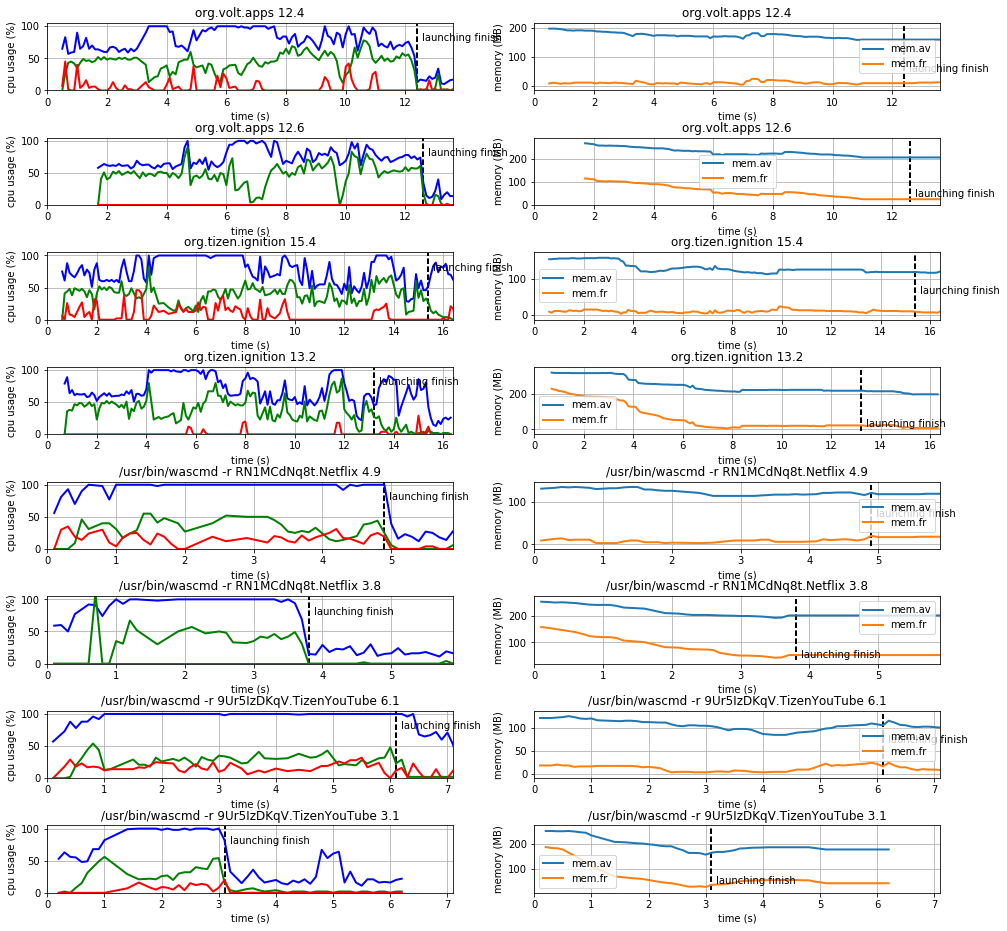

In [278]:
#show("../pr_disabled_20170523_172240.txt")
compare_all("../pr_disabled_20170523_182259.txt", "../pr_enabled_20170523_183121.txt")
#compare("../pr_enabled_20170523_161429.txt", "../pr_enabled_20170523_164541.txt", 5)